# API call

In [1]:
#import essential libraries 
import requests              #for api request
import pandas as pd

In [2]:
#method to get the current url
def get_url(page_number):    
    page = str(page_number)   
    url = 'https://api.stackexchange.com/2.2/questions?page=' + page + '&pagesize=100&order=desc&sort=activity&site=datascience'; 
    return url

#method to check api response validity
def response_validity(api_response):
    try:
        api_status = int(api_response.status_code)
    except ValueError:
        return None
    return True

#method to convert json to dataframe
def json_to_df(api_response):
    data = api_response.json()    
    try:
        df = pd.json_normalize(data['items'])
    except KeyError:
        return None
    df2 = df['tags']
    return df2


In [8]:
#variable to check no. of entries and df obj. to keep the records
page_number=1
records = pd.DataFrame()

#to receive the required 10000 records from the api
while page_number<=2:    
    url = get_url(page_number);
    api_response = requests.get(url)   
    
    #exception handling for failure of call response
    if response_validity(api_response) is None:
        continue
    
    #converting json to df obj.
    df2 = json_to_df(api_response)    
    
    #exception handling for error message from the server
    if df2 is None:
        e = api_response.json()
        print (e['error_message'])  #print error message e.g. containing wait time info
                                    #if too many requests are refused by the server and break 
        break
    
    #adding rows to already existing records
    frames = [records, df2]
    records = pd.concat(frames, ignore_index=True)
    page_number+=1;

#check for missing data for non empty df. object  
if not records.empty:
    records.columns = ['tags']

records.tail()

,tags
195,"[nltk, cosine-distance]"
196,"[classification, nlp, transfer-learning, text-..."
197,"[machine-learning, deep-learning, information-..."
198,"[neural-network, deep-learning, classification..."
199,"[python, keras, regression, lstm, accuracy]"


In [19]:
#local back-up of the records
#records.to_csv('Data/tags.csv')

# Problem 1: Weighted Graph

In [1]:
#import essential libraries
import pandas as pd
import ast                  #for text processing

import itertools
import collections


import networkx as nx      #networkx for w. graph
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read records (step can be skipped if API call was executed beforehand)
records = pd.read_csv('Data/tags.csv',index_col=0)
records.tail()

,tags
9995,"['deep-learning', 'convnet', 'batch-normalizat..."
9996,"['python', 'nlp', 'natural-language-process', ..."
9997,"['gaussian', 'gaussian-process']"
9998,"['scikit-learn', 'svm']"
9999,"['normalization', 'gan', 'regularization', 'ma..."


In [3]:
#save the dataframe as a list of row lists
rows_list = []

i=0
while i < len(records.index):
    row = str(records.iloc[i,0])
    row = ast.literal_eval(row) 
    rows_list.append(row)
    i = i + 1
    
print(len(rows_list[9999]))
x = len(rows_list[9999])-1
print(rows_list[9999][x])

5
mathematics


In [4]:
#combine all the tags in a single list
rows_concat = list(itertools.chain.from_iterable(rows_list))
counts = collections.Counter(rows_concat)

#remove term frequency from the dictionary (there may be other uses to it though)
key_tags = list(counts.keys())
len(key_tags) #we have these number of nodes

575

In [5]:
#create a new weighted graph
G=nx.Graph() 

#add nodes for each of the key tags 
G.add_nodes_from(key_tags)

#create or change edge weights based on prior condition/value 
#for between cluster of the key tags
for row in rows_list:
    for i in range(len(row)):
        for j in range(i + 1, len(row)):
            if G.has_edge(row[i],row[j]):
                G[row[i]][row[j]]['weight'] = G[row[i]][row[j]]['weight'] + 1
            else:
                G.add_edge(row[i],row[j], weight=1)


In [206]:
def save_graph(graph,file_name):
    #initialze Figure
    plt.figure(num=None, figsize=(20, 20), dpi=80)
    plt.axis('off')
    fig = plt.figure(1)
    pos = nx.spring_layout(graph)
    nx.draw_networkx_nodes(graph,pos)
    nx.draw_networkx_edges(graph,pos)
    nx.draw_networkx_labels(graph,pos)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    plt.xlim(0, xmax)
    plt.ylim(0, ymax)

    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

#Assuming that the graph G has nodes and edges entered
save_graph(G,"my_graph.pdf")

#it can also be saved in .svg, .png. or .ps formats

In [207]:
nx.write_gexf(G, "file2.gexf", version="1.2draft")

# Problem 2: Brute Force graph-based Recommendation

In [8]:
from collections import Counter

In [11]:
#method to return list of tags which are related to a search query 
#version 2.1, handles multiple tags
def tag_query(key_tag):
    word_split = str(key_tag).split()
    sum_dict = {}

    for i in word_split:
        temp_dict = {}
        edges = list(G.edges(str(key_tag))) #returns a list of all the edges from EdgeDataView

        for edge in edges:
            x = G.get_edge_data(edge[0],edge[1])
            temp_dict[edge[1]] = x['weight']

        sum_dict = dict(Counter(sum_dict) + Counter(temp_dict))       

    if sum_dict:
        result = sorted(sum_dict.items(), key=lambda x: x[1], reverse=True)
        result = [item[0] for item in result]
        result = ' | '.join(result)
        
    else:
        result = 'No results match your search query'
        
    return result

print(tag_query('nlp'))

machine-learning | python | deep-learning | word-embeddings | text-mining | bert | natural-language-process | neural-network | classification | word2vec | named-entity-recognition | transformer | lstm | nltk | keras | spacy | scikit-learn | sentiment-analysis | tfidf | text-classification | tensorflow | clustering | language-model | stanford-nlp | text | pytorch | rnn | topic-model | dataset | machine-translation | similarity | cnn | feature-selection | text-generation | lda | gensim | unsupervised-learning | attention-mechanism | question-answering | data-mining | information-retrieval | transfer-learning | encoding | embeddings | feature-engineering | data-science-model | feature-extraction | preprocessing | openai-gpt | ocr | ml | svm | python-3.x | chatbot | multilabel-classification | naive-bayes-classifier | machine-learning-model | corpus | huggingface | data-augmentation | speech-to-text | automatic-summarization | pandas | training | data | recommender-system | sequence-to-seq

In [12]:
print(tag_query('datascience'))

bigdata | python | machine-learning | statistics | programming | apache-hadoop | map-reduce


In [67]:
a = tag_query('nlp')
    
if a:
    print (a)
else:
    print('No results match your search query')

['machine-learning', 'python', 'deep-learning', 'word-embeddings', 'text-mining', 'bert', 'natural-language-process', 'neural-network', 'classification', 'word2vec', 'named-entity-recognition', 'transformer', 'lstm', 'nltk', 'keras', 'spacy', 'scikit-learn', 'sentiment-analysis', 'tfidf', 'text-classification', 'tensorflow', 'clustering', 'language-model', 'stanford-nlp', 'text', 'pytorch', 'rnn', 'topic-model', 'dataset', 'machine-translation', 'similarity', 'cnn', 'feature-selection', 'text-generation', 'lda', 'gensim', 'unsupervised-learning', 'attention-mechanism', 'question-answering', 'data-mining', 'information-retrieval', 'transfer-learning', 'encoding', 'embeddings', 'feature-engineering', 'data-science-model', 'feature-extraction', 'preprocessing', 'openai-gpt', 'ocr', 'ml', 'svm', 'python-3.x', 'chatbot', 'multilabel-classification', 'naive-bayes-classifier', 'machine-learning-model', 'corpus', 'huggingface', 'data-augmentation', 'speech-to-text', 'automatic-summarization', 

# Problem 3: Demo App

In [210]:
#to be first written in another text file 

# Recycle bin (dump code)

In [33]:
i = list(tuple(l) for l in rows_list)
i

[('regularization',),
 ('python', 'nlp', 'topic-model', 'lda', 'gensim'),
 ('classification',
  'predictive-modeling',
  'statistics',
  'random-forest',
  'multilabel-classification'),
 ('nlp', 'stanford-nlp', 'question-answering'),
 ('machine-learning', 'neural-network', 'deep-learning', 'nlp', 'cnn'),
 ('image-classification',),
 ('python', 'keras', 'tensorflow', 'accuracy', 'mnist'),
 ('nlp', 'clustering'),
 ('deep-learning', 'classification', 'predictive-modeling'),
 ('python', 'web-scraping'),
 ('sentiment-analysis',),
 ('correlation', 'parameter-estimation', 'estimators'),
 ('statistics', 'data-analysis', 'sampling', 'parameter-estimation', 'infere'),
 ('data', 'kaggle'),
 ('research', 'hypothesis-testing'),
 ('machine-learning', 'feature-selection', 'logistic-regression'),
 ('machine-learning', 'classification', 'dataset', 'predictive-modeling'),
 ('machine-learning', 'linear-regression', 'xgboost', 'data-product'),
 ('reference-request', 'ocr'),
 ('machine-learning', 'python',

In [69]:
#code needs correction to not replicate same words
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(rows_list)

# Create Corpus
texts = rows_list

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

#print(corpus)

len(corpus)

[[(0, 1)]]


10000

In [71]:
"""If you want to see what word a given id corresponds to, 
   pass the id as a key to the dictionary."""

id2word[0]

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:2]]

[[('regularization', 1)],
 [('gensim', 1), ('lda', 1), ('nlp', 1), ('python', 1), ('topic-model', 1)]]

In [ ]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install networkx

In [ ]:
from urllib2 import Request, urlopen
import json

import pandas as pd    

path1 = '42.974049,-81.205203|42.974298,-81.195755'
request=requests.get('http://maps.googleapis.com/maps/api/elevation/json?locations='+path1+'&sensor=false')
response = urlopen(request)
elevations = result1.read()
data = json.loads(elevations)
df = pd.json_normalize(data['results'])

In [ ]:
#data in text format
#result1.text
""""data = result1.json()

df = pd.json_normalize(data['items'])
df2 = df['tags']
df2.tail()

len(df2.index)
"""""


In [ ]:
#request and store data fetched via the api
result1 = requests.get('https://api.stackexchange.com/2.2/questions?page=1&pagesize=100&order=desc&sort=activity&site=datascience')
result2 = requests.get('https://api.stackexchange.com/2.2/questions?page=2&pagesize=100&order=desc&sort=activity&site=datascience')

In [ ]:
#check the success of an api
print(result1.status_code)
print(result2.status_code)

In [ ]:
try:
    api_status = int(api_response.status_code)
except ValueError:
    continue

In [ ]:
#data in json format
result = result2.json()

df = pd.DataFrame(result)
df.head()
#data = json.loads(result)
#df = pd.json_normalize(data['results'])

In [ ]:
import json

In [ ]:
#response.read(result1)
#data = json.loads(result1)
elevations = result1.read()

In [ ]:
pd.read_json(result1)

In [ ]:
    try:
        api_status = int(api_response.status_code)
    except ValueError:
        continue

In [43]:
my_list = records.iloc[3]

import ast
x = u'[ "A","B","C" , " D"]'
x = str(records.iloc[3,0])
x = ast.literal_eval(x)

print(x)

print(len(x))

#x = [n.strip() for n in x]
#print(x)


'''

x = ast.literal_eval(my_list)
print(x)
print(len(x))

print(x)



len(x)
type(x)

print(x[1])'''

['deep-learning', 'cnn']
2


'\n\nx = ast.literal_eval(my_list)\nprint(x)\nprint(len(x))\n\nprint(x)\n\n\n\nlen(x)\ntype(x)\n\nprint(x[1])'

In [36]:
[tuple(l) for l in rows_list]

[('regularization',),
 ('python', 'nlp', 'topic-model', 'lda', 'gensim'),
 ('classification',
  'predictive-modeling',
  'statistics',
  'random-forest',
  'multilabel-classification'),
 ('nlp', 'stanford-nlp', 'question-answering'),
 ('machine-learning', 'neural-network', 'deep-learning', 'nlp', 'cnn'),
 ('image-classification',),
 ('python', 'keras', 'tensorflow', 'accuracy', 'mnist'),
 ('nlp', 'clustering'),
 ('deep-learning', 'classification', 'predictive-modeling'),
 ('python', 'web-scraping'),
 ('sentiment-analysis',),
 ('correlation', 'parameter-estimation', 'estimators'),
 ('statistics', 'data-analysis', 'sampling', 'parameter-estimation', 'infere'),
 ('data', 'kaggle'),
 ('research', 'hypothesis-testing'),
 ('machine-learning', 'feature-selection', 'logistic-regression'),
 ('machine-learning', 'classification', 'dataset', 'predictive-modeling'),
 ('machine-learning', 'linear-regression', 'xgboost', 'data-product'),
 ('reference-request', 'ocr'),
 ('machine-learning', 'python',

In [44]:
#create nodes for each unique word
G = nx.Graph()   # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_weighted_edges_from([('0', 1, 2), (1, 2, 7.5)])

pos = nx.spring_layout(G)  # positions for all nodes

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()


TypeError: 'int' object is not iterable

In [ ]:
G=nx.Graph() 

# this is a bit easier then adding each node in a loop 
G.add_nodes_from(key_tags)

# show type and content of G.nodes() 
#print(G.nodes())
#print(type(G.nodes()))

trash = []

trial = rows_list[1:100]

for row in rows_list:
    for i in range(len(rows_list)):
        for j in range(i + 1, len(rows_list)):
            trash.append(rows_list[i])                      
            trash.append(rows_list[j])

            



G.add_edge('a', 'b', weight=0.6)

d = G.get_edge_data('a','b')
d['weight']

G.has_edge('a','n')

print(trash)

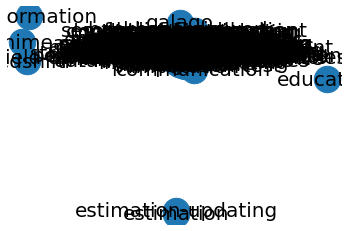

In [104]:
pos = nx.spring_layout(G)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos)

# labels
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [141]:
print(G.get_edge_data('python','lda'))
#list(G.nodes(data='python'))
#dict(G.nodes(data='weight'))

{'weight': 10}


In [194]:
#nx.shortest_path(G, source='python')

In [13]:
#method to return list of tags which are related to a search query (version 1.1)
def tag_query(key_tag):
    r = []
    edges = list(G.edges(str(key_tag))) #returns all the edges in EdgeDataView
    
    for edge in edges:
        x = G.get_edge_data(edge[0],edge[1])
        r.append([x['weight'],edge[1]])

    r.sort()
    r.reverse()
    
    r = [item[1] for item in r]
    
    return r

In [59]:
print(tag_query('datascience'))

['python', 'python', 'bigdata', 'bigdata', 'statistics', 'statistics', 'programming', 'programming', 'map-reduce', 'map-reduce', 'machine-learning', 'machine-learning', 'apache-hadoop', 'apache-hadoop']
